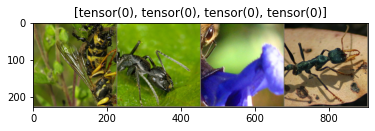

Epoch 0/24
----------
train Loss:0.5683 Acc:0.7418
val Loss:0.2400 Acc:0.9346

Epoch 1/24
----------
train Loss:0.5764 Acc:0.7787
val Loss:0.4561 Acc:0.8235

Epoch 2/24
----------
train Loss:0.5228 Acc:0.7787
val Loss:0.3917 Acc:0.8627

Epoch 3/24
----------
train Loss:0.5643 Acc:0.7787
val Loss:0.3312 Acc:0.8693

Epoch 4/24
----------
train Loss:0.6050 Acc:0.7500
val Loss:0.3918 Acc:0.8301

Epoch 5/24
----------
train Loss:0.3984 Acc:0.8484
val Loss:0.2910 Acc:0.8954

Epoch 6/24
----------
train Loss:0.3377 Acc:0.8443
val Loss:0.1844 Acc:0.9085

Epoch 7/24
----------
train Loss:0.2886 Acc:0.8934
val Loss:0.1812 Acc:0.9216

Epoch 8/24
----------
train Loss:0.2594 Acc:0.8811
val Loss:0.1921 Acc:0.9216

Epoch 9/24
----------
train Loss:0.3301 Acc:0.8566
val Loss:0.2495 Acc:0.8954

Epoch 10/24
----------
train Loss:0.3536 Acc:0.8730
val Loss:0.1716 Acc:0.9281

Epoch 11/24
----------
train Loss:0.2050 Acc:0.9139
val Loss:0.1827 Acc:0.9281

Epoch 12/24
----------
train Loss:0.4287 Acc:0.832

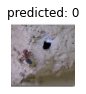

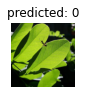

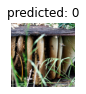

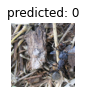

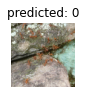

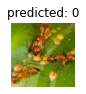

TypeError: train_model() got an unexpected keyword argument 'num_epoch'

In [2]:
from __future__ import print_function, division
import torch 
import torch.nn as nn 
import torch.optim as optim 
from torch.optim import lr_scheduler 
import numpy as np 
import torchvision 
from torchvision import datasets, models, transforms 
import matplotlib.pyplot as plt 
import time 
import os 
import copy

plt.ion() # 交互模式

data_transforms = { 
    "train": transforms.Compose([ 
        transforms.RandomResizedCrop(224), 
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(), 
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) 
        #两个参数分别代表均值mean和方差std，有三个值是对应三类像素image=[R,G,B] 
        #Normalized_image=(image-mean)/std 
    ]), 
    "val": transforms.Compose([ 
        transforms.Resize(256), 
        transforms.CenterCrop(224), 
        transforms.ToTensor(), 
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) 
    ])
}

data_dir = "hymenoptera_data" 

image_datasets = { 
    x: datasets.ImageFolder(root=os.path.join(data_dir, x), transform=data_transforms[x]) 
    for x in ["train", "val"] 
}

dataloaders = { 
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 4, shuffle = True, num_workers = 0) 
    #linux可以多线程加载数据，windows不可以 
    for x in ["train", "val"] 
} 
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]} 
class_names = image_datasets["train"].classes 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def imshow(inp, title=None): 
    inp = inp.numpy().transpose((1, 2, 0)) 
    mean = np.array([0.485, 0.456, 0.406]) 
    std = np.array([0.229, 0.224, 0.225]) 
    inp = std * inp + mean 
    inp = np.clip(inp, 0, 1) 
    plt.imshow(inp) 
    
    if title is not None: 
        plt.title(title) 
    
    plt.pause(0.001)

inputs, class_names = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs) 

imshow(out, title = [class_names[x] for x in class_names])

def train_model(model, criterion, optimizer, scheduler, num_epochs=25): 
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()
                #训练模式
            else:
                model.eval()
                #评估模式

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss:{:.4f} Acc:{:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    
    model.load_state_dict(best_model_wts)
    return model
 
#可视化
def visualize_model(model, num_images = 6):
    was_training = model.training
    model.eval()
    #model.trian()启用BatchNormalization和Dropout
    #一般用在训练集
    #model.eval()不启用BatchNormalization和Dropout
    #一般用在测试集
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs,1)
            #torch.max(input, dim, keepdim=False, out=None) 
            #按维度dim 返回最大值，并且返回索引。
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2,2,images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                #由于imshow不能作用在gpu的数据上, 因此需要先将其移动到cpu上
                
                if images_so_far == num_images:
                    model.train(mode = was_training)
                    return
        model.train(mode = was_training)


model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 观察到所有参数都被优化
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 每7个周期，LR衰减0.1倍
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


        
#trian and evaluate

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

visualize_model(model_ft)

model_conv = models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_ft.fc.in_features
model_conv.fc = nn.Linear(num_ftrs,2)

model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

# 观察到与之前相比，只有最后一层的参数被优化
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 每7个周期，LR衰减0.1倍
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epoch=25)
visualize_model(model_conv)

plt.ioff()
plt.show()